C:\Users\Nicholas\AppData\Local\Temp\ipykernel_21092\1869901000.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  split_div['div_id'] = split_div['div_id'].str.replace('.html', '')


(1.0, 1.0, 1.0, 1.0)


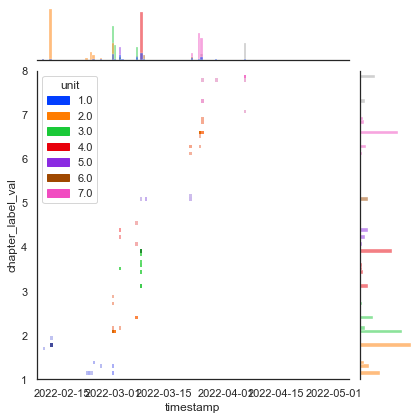

In [231]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default = 'warn'

log = pd.read_csv('data/data_log.csv', index_col=0)
actByInt = pd.read_csv('data/activity_by_interaction.csv', index_col=0)
actBySub = pd.read_csv('data/activity_by_subchapter.csv', index_col=0)

REMOVE_ADMINS = True

sid_map = {}
name_map = {}

# Rename chapter_activity headers to match student id (sid) in data_log
# Assuming actByInt and actBySub have same names in columns headers
for name in actByInt.columns:

    # Split over '<br>' tag and store in dictionaries
    if '<br>' in name:
        full_name = name[:name.index('<')]
        sid = name[name.index('>') + 2:-1]
        sid_map[sid] = full_name
        name_map[name] = sid

actByInt.rename(columns=name_map, inplace=True)
actBySub.rename(columns=name_map, inplace=True)

# Drop administrator activity
# Note: Found student event with admin type, so must also filter for admin actions

admins = log.query('event == "admin" & act == "admin"')['sid'].unique()

if REMOVE_ADMINS:
    log = log[log['sid'].isin(admins) == False]
    actByInt.drop(columns=admins,inplace=True)
    actBySub.drop(columns=admins, inplace=True)

# Sometimes the div_id column contains the chapter/subchapter field, so need to split and move to chapter and subchapter columns
split_div = log[log['div_id'].str.contains('Unit\\d',regex=True) & ~log['div_id'].str.contains('toctree')]

split_div['div_id'] = split_div['div_id'].str.replace('.html', '')
split_div['chapter'] = split_div['div_id'].map(lambda x : x.split('/')[0])
split_div['subchapter'] = split_div['div_id'].map(lambda x : x.split('/')[-1]) # Need to use -1 because not all unit div_id's have a '/subchapter'

log[log['div_id'].str.contains('Unit\\d',regex=True) & ~log['div_id'].str.contains('toctree')] = split_div

# Create a chapter_label_val column with float values assigned to each subchapter, in order of content progression.
log['chapter_label_val'] = log['chapter'] + '/' + log['subchapter']
log['chapter_label_val'] = log['chapter_label_val'].map(lambda x : \
                                                   float(actBySub.loc[actBySub['chapter_label'].str.contains(x),'chapter_label'].iloc[0].split(' ')[0]) \
                                                   if 'Unit' in x else np.nan)


# Create scatterplot where x-axis is time, and y-axis represents a linear ordering of the subchapters, determined by a comparable subchapter code
# size can be constant, 1 point for each activity, for the most granular continuous view - or can cluster activities into bubbles by total interactions
# Make a joint plot with a histogram of the subchapter activity on the right to show total interaction with each subchapter
# and a day-wise histogram on top to show total activity for each day

log['timestamp'] = pd.to_datetime(log['timestamp'])
log['unit']=np.floor(log['chapter_label_val']).astype('str')
student = log[log['sid'] == 'johnme']

first_day = log['timestamp'].dt.date.min()
last_day = log['timestamp'].dt.date.max()
num_days = int((last_day - first_day).days)

num_units = len(log['unit'].dropna().unique())

sns.set_style('white')
sns.set_palette('bright')
g = sns.jointplot(data=student, x='timestamp',y='chapter_label_val',hue='unit',kind='hist',dropna=True, \
              joint_kws=dict(bins=num_days), marginal_kws=dict(bins=num_days),\
              xlim=(first_day,last_day),ylim=(1,num_units))

sns.move_legend(g.ax_joint, loc='upper left')
plt.show()

# - Add sliders
# - Class aggregate
# - Add to FacetGrid for whole class